这个单元格给助教，请忽略!

### Score:

### Comment: 

请实现每个 function 内容，确保最终提交的notebook是可以运行的。

每一题除了必须要报告的 输出/图表，可以添加解释（中文即可）。此外可以自定义其他 function / 变量，自由添加单元格，但请确保题目中给出的 function （如第一题的 Print_values）可以正常调用。

**Collaboration:**  

Collaboration on solving the assignment is allowed, after you have thought about the problem sets on your own. It is also OK to get clarification (but not solutions) from online resources, again after you have thought about the problem sets on your own. 

There are two requirements for collaboration: 

* Cite your collaborators **fully and completely** (*e.g.*, "XXX explained to me what is asked in problem set 3"). Or cite online resources (*e.g.*, "I got inspired by reading XXX") that helped you.

* Write your scripts and report **independently** - the scripts and report must come from you only.

## 1. Modeling of carbon cycle
In this problem, we will build a box model to understand the Earth’s carbon cycle based on the framework in Tomizuka 2009.

1.1 [15 points] Following equation 1-2 (without the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm (parts per million) from 1987 to 2004.

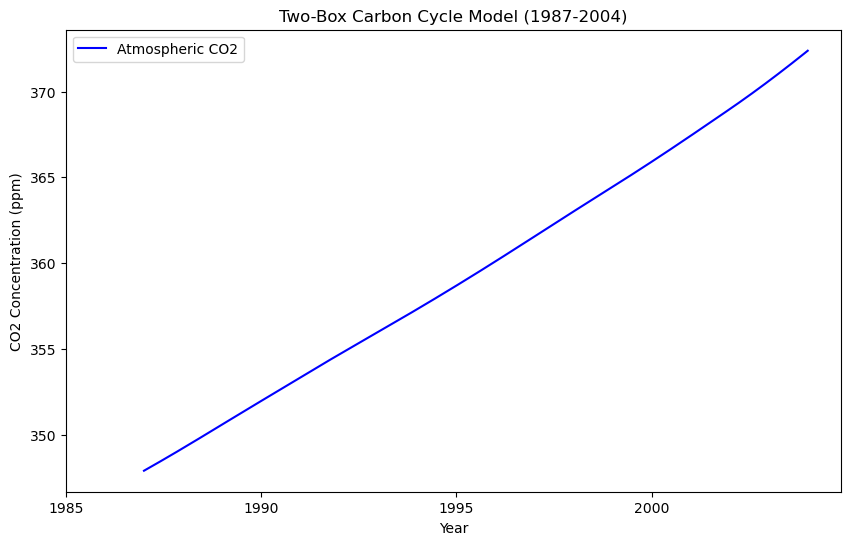

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

# 加载数据
data = pd.read_csv('global.1751_2014_new.csv')

# 提取1987年到2024年的CO2排放数据
gamma_data = data.loc[(data['Year'] >= 1987) & (data['Year'] <= 2004), 
                      ['Year', 'Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)']]

# 单位转换：从百万公吨转换为ppm
gamma_data['gamma'] = gamma_data.iloc[:, 1] / 1000 / 2.127

# 定义一个函数，用于根据时间插入γ值
def get_gamma(t):
    """
    根据给定的时间t插值γ值。
    """
    years = gamma_data['Year'] - 1987  # 调整年份，从0开始
    gamma_values = gamma_data['gamma']
    return np.interp(t, years, gamma_values)

# 定义模型参数（根据论文的描述获取）
k12 = 105 / 740  # 大气到海洋的传输系数
k21 = 102 / 900  # 海洋到大气的传输系数

# 定义方程1-2用于建模
def carbon_flux(y, t):
    """
    定义耦合微分方程。
    y[0] = N1 (大气中的CO2)
    y[1] = N2 (海平面CO2)
    """
    N1, N2 = y
    
    # 通过上述函数获取γ数据
    gamma = get_gamma(t)
    
    # 模型中的方程
    dN1_dt = -k12 * N1 + k21 * N2 + gamma
    dN2_dt = k12 * N1 - k21 * N2
    
    return [dN1_dt, dN2_dt]

# 设置时间点 (1987到2004年)
t = np.linspace(0, 17, 204)  # 每月分辨率，共17年

# 初始条件（1987年的ppm值）
N1_0 = 740/2.127  # 1987年大气中CO2浓度 (740PgC)
N2_0 = 900/2.127  # 海平面CO2的近似值 (900PgC)
y0 = [N1_0, N2_0]

# 求解微分方程
solution = odeint(carbon_flux, y0, t)

# 提取结果
N1_solution_without_buffer = solution[:, 0]  # 大气中的CO2
N2_solution_without_buffer = solution[:, 1]  # 海平面CO2

# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(1987 + t, N1_solution_without_buffer, 'b-', label='Atmospheric CO2')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
plt.title('Two-Box Carbon Cycle Model (1987-2004)')
plt.grid(False)
plt.legend()
# 修改x轴刻度
plt.xticks(ticks=np.arange(1985, 2005, 5), labels=[str(year) for year in np.arange(1985, 2005, 5)])
plt.show()


1.2 [20 points] Following equation 3-4 (with the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm from 1987 to 2004.

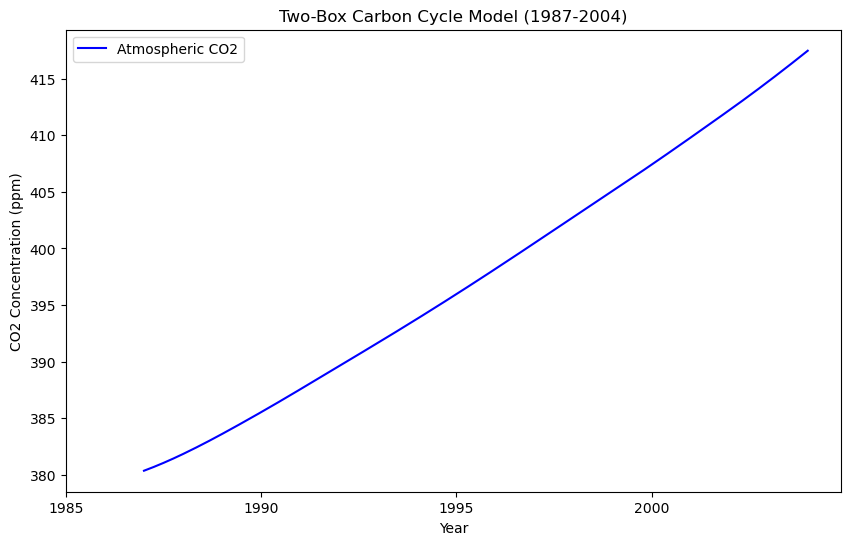

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

# 从文件中加载γ值
data = pd.read_csv('global.1751_2014_new.csv')

# 提取年份和总碳排放数据 (1987-2004)
gamma_data = data.loc[(data['Year'] >= 1987) & (data['Year'] <= 2004), 
                      ['Year', 'Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)']]

# 将碳排放数据转换为PgC/年 (除以1000) 单位：百万公吨，需要转换成ppm
gamma_data['gamma'] = gamma_data.iloc[:, 1] / 1000 / 2.13

# 定义一个函数，用于插值γ值
def get_gamma(t):
    """
    根据给定的时间t插值γ值。
    """
    years = gamma_data['Year'] - 1987  # 调整年份，从0开始
    gamma_values = gamma_data['gamma']
    return np.interp(t, years, gamma_values)

# 定义模型参数
k12 = 105 / 809  # 从大气到海洋的传输系数
k21 = 102 / 821  # 从海洋到大气的传输系数

# 平衡值
N2_eq = 821 / 2.127  # 海洋平衡值 (821PgC = 900 − 79)
xi = 3  # 缓冲因子示例，可根据需要修改

# 微分方程
def carbon_flux(y, t):
    """
    定义耦合微分方程。
    y[0] = N1 (大气中的CO2)
    y[1] = N2 (海洋表面CO2)
    """
    N1, N2 = y
    
    # 获取当前时间t的γ值
    gamma = get_gamma(t)
    
    # 模型中的方程
    dN1_dt = -k12 * N1 + k21 * (N2_eq + xi * (N2 - N2_eq)) + gamma
    dN2_dt = k12 * N1 - k21 * (N2_eq + xi * (N2 - N2_eq))
    
    return [dN1_dt, dN2_dt]

# 设置时间点 (1987到2004年)
t = np.linspace(0, 17, 204)  # 每月分辨率，共17年

# 初始条件 (1987年的ppm值)
N1_0 = 809 / 2.127  # 1987年大气中的CO2浓度 (809PgC)
N2_0 = 821 / 2.127  # 海洋表面CO2的近似值 (821PgC)
y0 = [N1_0, N2_0]

# 求解微分方程
solution = odeint(carbon_flux, y0, t)

# 提取结果
N1_solution_with_buffer = solution[:, 0]  # 大气中的CO2
N2_solution_with_buffer = solution[:, 1]  # 海洋表面CO2


# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(1987 + t, N1_solution_with_buffer, 'b-', label='Atmospheric CO2')
# plt.plot(1987 + t, N2_solution, 'g-', label='Ocean Surface CO2')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
plt.title('Two-Box Carbon Cycle Model (1987-2004)')
plt.grid(False)
plt.legend()
# 修改x轴刻度
plt.xticks(ticks=np.arange(1985, 2005, 5), labels=[str(year) for year in np.arange(1985, 2005, 5)])
plt.show()

1.3 [5 points] Based on your results from 1.1 and 1.2, reproduce Figure 2 in Tomizuka (2009) as much as you can.

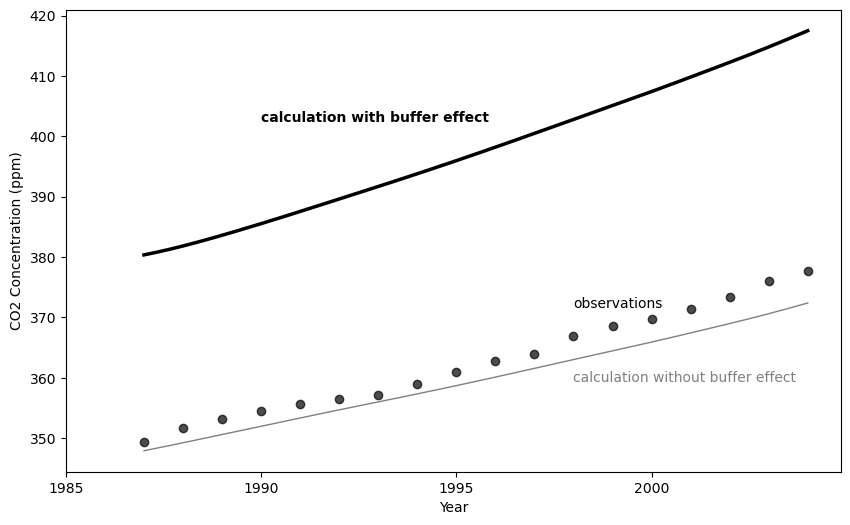

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 加载数据 (Mauna Loa CO2 data)
obs_data = pd.read_csv('co2_annmean_mlo.csv')

# 筛选1987年至2004年的观测数据
obs_data_filtered = obs_data[(obs_data['year'] >= 1987) & (obs_data['year'] <= 2004)]

# 提取筛选后的年份和CO2浓度
filtered_years = obs_data_filtered['year']
filtered_co2 = obs_data_filtered['mean']

# 绘制图像
plt.figure(figsize=(10, 6))
plt.plot(1987 + t, N1_solution_without_buffer, color='gray', linewidth=1, label='calculation without buffer effect')
plt.plot(1987 + t, N1_solution_with_buffer, color='black', linewidth=2.5, linestyle='-', label='calculation with buffer effect')
plt.scatter(filtered_years, filtered_co2, color='k', label='observations (Mauna Loa)', alpha=0.7)

# 设置标签的位置
plt.annotate('calculation without buffer effect', xy=(1998, N1_solution_without_buffer[-1]),
             xytext=(1998, N1_solution_without_buffer[-1] - 13), color='gray', fontsize=10)
plt.annotate('calculation with buffer effect', xy=(1990, N1_solution_with_buffer[-1]),
             xytext=(1990, N1_solution_with_buffer[-1] -15), color='black', fontsize=10, fontweight='bold')
plt.annotate('observations', xy=(1998, filtered_co2.mean()), xytext=(1998, filtered_co2.mean() + 9), 
             color='black', fontsize=10)

plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
plt.grid(False)
# plt.legend()
# 修改x轴刻度
plt.xticks(ticks=np.arange(1985, 2005, 5), labels=[str(year) for year in np.arange(1985, 2005, 5)])
plt.show()
